<a href="https://colab.research.google.com/github/neerajkumarvaid/Individual_Survival_Prediction/blob/main/SurvivalEVAL_for_PyCox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Evaluation for Pycox model**

In this notebook we introduce the use of PycoxEvaluator in the package through an example dataset and a model. The first half of this notebook follows the procedure described in the Pycox example.

In the following we will:

Load the METABRIC survival dataset and create a LogisticHazard model;
Train the model using training set;
Evaluate the performance using the concordance, Brier score, L1 loss, 1-calibration, and D-calibration.

**Import Dependencies**

Note: You need sklearn-pandas for normalizing the data.

In [6]:
#!pip install torchtuples
#!pip install pycox
!pip install scikit-survival

     |████████████████████████████████| 2.5 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.17.1-cp37-cp37m-linux_x86_64.whl size=4088303 sha256=3ac012a5a0c43174026b929537a720b74452f1458047dd61e15e010b099b32f5
  Stored in directory: /root/.cache/pip/wheels/78/43/46/b5c9ba2d44e7e5de3d321c76bbff4e5480cd69d486b38d359f
Successfully built scikit-survival


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard

from Evaluator import PycoxEvaluator

In [8]:
%matplotlib inline

In [9]:
# Set seed for torch and numpy

np.random.seed(1234)
_ = torch.manual_seed(123)

In [10]:
# Load the dataset, split it into training (64%), validation (16%) and testing set (20%). Then standardize the covariates.

df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')


Dataset 'metabric' not locally available. Downloading...
Done


In [11]:
# Build the model and train it.

num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
durations_train, events_train = get_target(df_train)

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.9263,	val_loss: 2.7659
1:	[0s / 0s],		train_loss: 2.6603,	val_loss: 2.5461
2:	[0s / 0s],		train_loss: 2.3791,	val_loss: 2.2354
3:	[0s / 0s],		train_loss: 2.0756,	val_loss: 1.9005
4:	[0s / 0s],		train_loss: 1.7898,	val_loss: 1.5965
5:	[0s / 0s],		train_loss: 1.5691,	val_loss: 1.4399
6:	[0s / 0s],		train_loss: 1.4533,	val_loss: 1.3834
7:	[0s / 0s],		train_loss: 1.4080,	val_loss: 1.3732
8:	[0s / 0s],		train_loss: 1.3977,	val_loss: 1.3749
9:	[0s / 0s],		train_loss: 1.3683,	val_loss: 1.3710
10:	[0s / 0s],		train_loss: 1.3406,	val_loss: 1.3672
11:	[0s / 0s],		train_loss: 1.3476,	val_loss: 1.3632
12:	[0s / 0s],		train_loss: 1.3404,	val_loss: 1.3599
13:	[0s / 0s],		train_loss: 1.3284,	val_loss: 1.3536
14:	[0s / 0s],		train_loss: 1.3253,	val_loss: 1.3544
15:	[0s / 0s],		train_loss: 1.3170,	val_loss: 1.3566
16:	[0s / 0s],		train_loss: 1.3101,	val_loss: 1.3618
17:	[0s / 0s],		train_loss: 1.3191,	val_loss: 1.3643
18:	[0s / 0s],		train_loss: 1.2992,	val_loss: 1.3638
19:

In [12]:
# Make the prediction. surv is a Dataframe object with index represents the time coordinates, and values represents the survival curves.

surv = model.interpolate(10).predict_surv_df(x_test)


In [13]:
# Build the evaluator. Training set information (durations_train and events_train) is optional if you don't need Brier score, integrated Brier score, and L1-margin loss.

eval = PycoxEvaluator(surv, durations_test, events_test, durations_train, events_train)


In [14]:
# Calculate the concordance index. ties argument indicates the way ties should be handled. predicted_time_method argument indicates whether using median or mean survival time as the predicted time.
cindex, concordant_pairs, total_pairs = eval.concordance(ties="None", predicted_time_method="Median")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))


Concordance index is 0.6424180762219679, meaning that the model can correctly order 30308.0 pairs among 47178.0 comparable pairs in the testing set.


In [15]:
# Calculate the Brier score at time 175.
bs = eval.brier_score(target_time=175)
print("Brier score at time 175 is {}.".format(bs))

Brier score at time 175 is 0.2130840160707278.


In [16]:
# Calculate the l1-margin loss using mean survival times obtain from the survival curves as the predicted survival times. You can set method as 'Hinge' or 'Uncensored' for different l1 loss calculation.
l1 = eval.l1_loss(method='Margin', predicted_time_method="Mean")
print("L1-margin loss is {}.".format(l1))

/content/Evaluations/util.py:192: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=(max_time, slope), limit=1000)


L1-margin loss is 78.61145942387915.


In [17]:
# L1 Hinge loss calculation
l1 = eval.l1_loss(method='Hinge', predicted_time_method="Median")
print("L1-Hinge loss is {}.".format(l1))

L1-Hinge loss is 52.07374887196903.


In [18]:
# Run one calibration test at 50% time of the testing set.

t_time = round(np.percentile(durations_test, 50))
p_value, ob, pre = eval.one_calibration(target_time=t_time, method="DN")
if p_value >= 0.05:
    print("The model is one-calibrated at time {}.".format(t_time))
else:
    print("The model is not one-calibrated at time {}.".format(t_time))


The model is one-calibrated at time 113.


<Figure size 432x288 with 0 Axes>

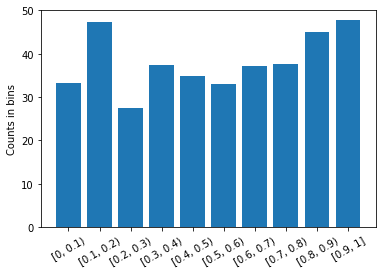

The model is d-calibrated!


In [19]:
# Run distribution calibration test.

p_value_2, bin_statistics = eval.d_calibration()
bins = ["[0, 0.1)", "[0.1, 0.2)", "[0.2, 0.3)", "[0.3, 0.4)", "[0.4, 0.5)", "[0.5, 0.6)", "[0.6, 0.7)", "[0.7, 0.8)",
        "[0.8, 0.9)", "[0.9, 1]"]
plt.clf()
fig, ax = plt.subplots()
ax.bar(bins, bin_statistics)
plt.setp(ax.get_xticklabels(), rotation=30)
plt.ylabel("Counts in bins")
plt.show()
if p_value_2 >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")